# **Train model Mask R-CNN with custom dataset**
* Dataset: coco
* framework: pytorch

## Prepare

### Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/TrainPBL-customData

/content/drive/.shortcut-targets-by-id/1sHXKxNtMQWtoH5fUwp1xjYsCKKzaKOAj/TrainPBL-customData


### Setting up environment

In [ ]:
%%capture
# Install PyTorch with CUDA 11.8
# %pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install torch==1.13.1+cu118 torchvision==0.14.1+cu118 torchaudio==0.13.1+cu118 --index-url https://download.pytorch.org/whl/cu118

# Install additional dependencies
!pip install matplotlib pandas pillow torchtnt==0.2.0 tqdm tabulate

# Install package for creating visually distinct colormaps
!pip install distinctipy

# Install utility packages
!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

In [ ]:
!pip install pycocotools

### Importing the Required Dependencies

In [ ]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

In [ ]:
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image, ImageDraw
from torchvision.transforms.v2.functional import to_tensor, to_pil_image

### Setting up project

#### Setting a Random Number Seed

In [ ]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

#### Setting the Device and Data Type

In [ ]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cpu', torch.float32)

### Setting the Directory Paths

In [ ]:
# The name for the project
project_name = f"pytorch-mask-r-cnn-instance-segmentation-custom-data"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
# dataset_dir = Path("./coco/annotations/")
dataset_dir = Path("./coco/dataset/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Project Directory:": project_dir,
    "Dataset Directory:": dataset_dir
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-mask-r-cnn-instance-segmentation-custom-data
Dataset Directory:,coco/dataset


### Loading and Exploring the Dataset

#### Setting the Dataset Path

In [ ]:
# Set the name of the dataset
dataset_name = 'val2017'
# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

model_path = 'pytorch-mask-r-cnn-instance-segmentation/2024-06-05_08-57-25/maskrcnn_resnet50_fpn_v2.pth'

In [ ]:
# Get a list of image files in the dataset
img_file_paths = get_img_files(dataset_path)

# Load the annotation file
annotation_file = next(dataset_path.glob('../*.json'))

with open(annotation_file, 'r') as file:
    annotations_data = json.load(file)

# Extract the 'images' and 'annotations' from the JSON
images = annotations_data['images']
annotations = annotations_data['annotations']
categories = annotations_data['categories']

image_id_to_file = {image['id']: image['file_name'] for image in images}
# Create a list to hold the extracted data
extracted_data = []

for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_file:
        file_name = image_id_to_file[image_id]
        extracted_data.append({
            "Image File": file_name,
            "Annotation": annotation
        })

# Create a DataFrame to display the information
df = pd.DataFrame(extracted_data)
df.head()

,Image File,Annotation
0,000000289343.jpg,"{'segmentation': [[510.66, 423.01, 511.72, 420.03, 510.45, 416.0, 510.34, 413.02, 510.77, 410.26, 510.77, 407.5, 510.34, 405.16, 511.51, 402.83, 511.41, 400.49, 510.24, 398.16, 509.39, 397.31, 504.61, 399.22, 502.17, 399.64, 500.89, 401.66, 500.47, 402.08, 499.09, 401.87, 495.79, 401.98, 490.59, 401.77, 488.79, 401.77, 485.39, 398.58, 483.9, 397.31, 481.56, 396.35, 478.48, 395.93, 476.68, 396.03, 475.4, 396.77, 473.92, 398.79, 473.28, 399.96, 473.49, 401.87, 474.56, 403.47, 473.07, 405.59, 473.39, 407.71, 476.68, 409.41, 479.23, 409.73, 481.56, 410.69, 480.4, 411.85, 481.35, 414.93, 479.86, 418.65, 477.32, 420.03, 476.04, 422.58, 479.02, 422.58, 480.29, 423.01, 483.79, 419.93, 486.66, 416.21, 490.06, 415.57, 492.18, 416.85, 491.65, 420.24, 492.82, 422.9, 493.56, 424.39, 496.43, 424.6, 498.02, 423.01, ...]], 'area': 702.1057499999998, 'iscrowd': 0, 'image_id': 289343, 'bbox': [473.07, 395.93, 38.65, 28.67], 'category_id': 18, 'id': 1768}"
1,000000061471.jpg,"{'segmentation': [[289.74, 443.39, 302.29, 445.32, 308.09, 427.94, 310.02, 416.35, 304.23, 405.73, 300.14, 385.01, 298.23, 359.52, 295.04, 365.89, 282.3, 362.71, 275.29, 358.25, 277.2, 346.14, 280.39, 339.13, 284.85, 339.13, 291.22, 338.49, 293.77, 335.95, 295.04, 326.39, 297.59, 317.47, 289.94, 309.82, 287.4, 288.79, 286.12, 275.41, 284.21, 271.59, 279.11, 276.69, 275.93, 275.41, 272.1, 271.59, 274.01, 267.77, 275.93, 265.22, 277.84, 264.58, 282.3, 251.2, 293.77, 238.46, 307.79, 221.25, 314.79, 211.69, 325.63, 205.96, 338.37, 205.32, 347.29, 205.32, 353.03, 205.32, 361.31, 200.23, 367.95, 202.02, 372.27, 205.8, 382.52, 215.51, 388.46, 225.22, 399.25, 235.47, 399.25, 252.74, 390.08, 247.34, 386.84, 247.34, 388.46, 256.52, 397.09, 268.93, 413.28, 298.6, 421.91, 356.87, 424.07, 391.4, 422.99, 409.74, ...]], 'area': 27718.476299999995, 'iscrowd': 0, 'image_id': 61471, 'bbox': [272.1, 200.23, 151.97, 279.77], 'category_id': 18, 'id': 1773}"
2,000000472375.jpg,"{'segmentation': [[147.76, 396.11, 158.48, 355.91, 153.12, 347.87, 137.04, 346.26, 125.25, 339.29, 124.71, 301.77, 139.18, 262.64, 159.55, 232.63, 185.82, 209.04, 226.01, 196.72, 244.77, 196.18, 251.74, 202.08, 275.33, 224.59, 283.9, 232.63, 295.16, 240.67, 315.53, 247.1, 327.85, 249.78, 338.57, 253.0, 354.12, 263.72, 379.31, 276.04, 395.39, 286.23, 424.33, 304.99, 454.95, 336.93, 479.62, 387.02, 491.58, 436.36, 494.57, 453.55, 497.56, 463.27, 493.08, 511.86, 487.02, 532.62, 470.4, 552.99, 401.26, 552.99, 399.65, 547.63, 407.15, 535.3, 389.46, 536.91, 374.46, 540.13, 356.23, 540.13, 354.09, 536.91, 341.23, 533.16, 340.15, 526.19, 342.83, 518.69, 355.7, 512.26, 360.52, 510.65, 374.46, 510.11, 375.53, 494.03, 369.1, 497.25, 361.06, 491.89, 361.59, 488.67, 354.63, 489.21, 346.05, 496.71, 343.37, 492.42, ...]], 'area': 78969.31690000003, 'iscrowd': 0, 'image_id': 472375, 'bbox': [124.71, 196.18, 372.85, 356.81], 'category_id': 18, 'id': 2551}"
3,000000520301.jpg,"{'segmentation': [[260.4, 231.26, 215.06, 274.01, 194.33, 307.69, 195.63, 329.72, 168.42, 355.63, 120.49, 382.83, 112.71, 415.22, 159.35, 457.98, 172.31, 483.89, 229.31, 504.62, 275.95, 500.73, 288.91, 495.55, 344.62, 605.67, 395.14, 634.17, 480.0, 632.87, 480.0, 284.37, 404.21, 223.48, 336.84, 202.75, 269.47, 154.82, 218.95, 179.43, 203.4, 194.98, 190.45, 211.82, 233.2, 205.34]], 'area': 108316.66515000002, 'iscrowd': 0, 'image_id': 520301, 'bbox': [112.71, 154.82, 367.29, 479.35], 'category_id': 18, 'id': 3186}"
4,000000579321.jpg,"{'segmentation': [[200.61, 253.97, 273.19, 318.49, 302.43, 336.64, 357.87, 340.67, 402.23, 316.48, 470.78, 331.6, 521.19, 321.52, 583.69, 323.53, 598.81, 287.24, 600.83, 236.84, 584.7, 190.46, 580.66, 169.29, 531.27, 121.91, 472.8, 93.69, 420.38, 89.65, 340.74, 108.81, 295.37, 119.9, 263.11, 141.07, 233.88, 183.41, 213.72, 229.78, 200.61, 248.93]], 'area': 75864.53530000002, 'iscrowd': 0, 'image_id': 579321, 'bbox': [200.61, 89.65, 400.22, 251.02], 'category_id': 18, 'id': 3419}"


#### Get image file path

In [ ]:
# Create a dictionary that maps file names to file paths
img_dict = {file.stem : file for file in img_file_paths}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
# pd.DataFrame.from_dict(img_dict, orient='index').head()
pd.DataFrame.from_dict(img_dict, orient='index')

Number of Images: 5000


,0
000000482319,coco/dataset/val2017/000000482319.jpg
000000218439,coco/dataset/val2017/000000218439.jpg
000000571598,coco/dataset/val2017/000000571598.jpg
000000320642,coco/dataset/val2017/000000320642.jpg
000000379842,coco/dataset/val2017/000000379842.jpg
000000023899,coco/dataset/val2017/000000023899.jpg
000000575081,coco/dataset/val2017/000000575081.jpg
000000016958,coco/dataset/val2017/000000016958.jpg
000000075612,coco/dataset/val2017/000000075612.jpg
000000183049,coco/dataset/val2017/000000183049.jpg


#### Get image annotation

In [ ]:
# Create a dictionary to map category IDs to category names
category_id_to_name = {category['id']: category['name'] for category in categories}

# Create a dictionary to map image IDs to file names and other relevant info
image_id_to_info = {
    image['id']: {
        'file_name': image['file_name'],
        'height': image['height'],
        'width': image['width'],
    }
    for image in images
}

# Create a list to hold the extracted data
extracted_data = []

for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_info:
        image_info = image_id_to_info[image_id]
        category_id = annotation['category_id']
        category_name = category_id_to_name[category_id]
        extracted_data.append({
            "Image File": image_info['file_name'],
            "Annotation": annotation,
            "Height": image_info['height'],
            "Width": image_info['width'],
            "Category ID": category_id,
            "Category Name": category_name
        })

# Create a DataFrame to display the information
annotation_df = pd.DataFrame(extracted_data)

# Assign the image file name without extension as the index for each row
annotation_df['index'] = annotation_df['Image File'].apply(lambda x: Path(x).stem)
annotation_df = annotation_df.set_index('index')

# -----
# Normalize keys and index for case and whitespace consistency
img_dict_keys = [key.strip().lower() for key in img_dict.keys()]
annotation_df.index = annotation_df.index.str.strip().str.lower()
# -----

# # Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
# annotation_df = annotation_df.loc[list(img_dict.keys())] +++

# -----
# Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
annotation_df = annotation_df.loc[annotation_df.index.isin(img_dict_keys)]
# -----

# Print the first 5 rows of the DataFrame
annotation_df.head()

,Image File,Annotation,Height,Width,Category ID,Category Name
index,,,,,,
000000289343,000000289343.jpg,"{'segmentation': [[510.66, 423.01, 511.72, 420.03, 510.45, 416.0, 510.34, 413.02, 510.77, 410.26, 510.77, 407.5, 510.34, 405.16, 511.51, 402.83, 511.41, 400.49, 510.24, 398.16, 509.39, 397.31, 504.61, 399.22, 502.17, 399.64, 500.89, 401.66, 500.47, 402.08, 499.09, 401.87, 495.79, 401.98, 490.59, 401.77, 488.79, 401.77, 485.39, 398.58, 483.9, 397.31, 481.56, 396.35, 478.48, 395.93, 476.68, 396.03, 475.4, 396.77, 473.92, 398.79, 473.28, 399.96, 473.49, 401.87, 474.56, 403.47, 473.07, 405.59, 473.39, 407.71, 476.68, 409.41, 479.23, 409.73, 481.56, 410.69, 480.4, 411.85, 481.35, 414.93, 479.86, 418.65, 477.32, 420.03, 476.04, 422.58, 479.02, 422.58, 480.29, 423.01, 483.79, 419.93, 486.66, 416.21, 490.06, 415.57, 492.18, 416.85, 491.65, 420.24, 492.82, 422.9, 493.56, 424.39, 496.43, 424.6, 498.02, 423.01, ...]], 'area': 702.1057499999998, 'iscrowd': 0, 'image_id': 289343, 'bbox': [473.07, 395.93, 38.65, 28.67], 'category_id': 18, 'id': 1768}",640,529,18,dog
000000061471,000000061471.jpg,"{'segmentation': [[289.74, 443.39, 302.29, 445.32, 308.09, 427.94, 310.02, 416.35, 304.23, 405.73, 300.14, 385.01, 298.23, 359.52, 295.04, 365.89, 282.3, 362.71, 275.29, 358.25, 277.2, 346.14, 280.39, 339.13, 284.85, 339.13, 291.22, 338.49, 293.77, 335.95, 295.04, 326.39, 297.59, 317.47, 289.94, 309.82, 287.4, 288.79, 286.12, 275.41, 284.21, 271.59, 279.11, 276.69, 275.93, 275.41, 272.1, 271.59, 274.01, 267.77, 275.93, 265.22, 277.84, 264.58, 282.3, 251.2, 293.77, 238.46, 307.79, 221.25, 314.79, 211.69, 325.63, 205.96, 338.37, 205.32, 347.29, 205.32, 353.03, 205.32, 361.31, 200.23, 367.95, 202.02, 372.27, 205.8, 382.52, 215.51, 388.46, 225.22, 399.25, 235.47, 399.25, 252.74, 390.08, 247.34, 386.84, 247.34, 388.46, 256.52, 397.09, 268.93, 413.28, 298.6, 421.91, 356.87, 424.07, 391.4, 422.99, 409.74, ...]], 'area': 27718.476299999995, 'iscrowd': 0, 'image_id': 61471, 'bbox': [272.1, 200.23, 151.97, 279.77], 'category_id': 18, 'id': 1773}",480,640,18,dog
000000472375,000000472375.jpg,"{'segmentation': [[147.76, 396.11, 158.48, 355.91, 153.12, 347.87, 137.04, 346.26, 125.25, 339.29, 124.71, 301.77, 139.18, 262.64, 159.55, 232.63, 185.82, 209.04, 226.01, 196.72, 244.77, 196.18, 251.74, 202.08, 275.33, 224.59, 283.9, 232.63, 295.16, 240.67, 315.53, 247.1, 327.85, 249.78, 338.57, 253.0, 354.12, 263.72, 379.31, 276.04, 395.39, 286.23, 424.33, 304.99, 454.95, 336.93, 479.62, 387.02, 491.58, 436.36, 494.57, 453.55, 497.56, 463.27, 493.08, 511.86, 487.02, 532.62, 470.4, 552.99, 401.26, 552.99, 399.65, 547.63, 407.15, 535.3, 389.46, 536.91, 374.46, 540.13, 356.23, 540.13, 354.09, 536.91, 341.23, 533.16, 340.15, 526.19, 342.83, 518.69, 355.7, 512.26, 360.52, 510.65, 374.46, 510.11, 375.53, 494.03, 369.1, 497.25, 361.06, 491.89, 361.59, 488.67, 354.63, 489.21, 346.05, 496.71, 343.37, 492.42, ...]], 'area': 78969.31690000003, 'iscrowd': 0, 'image_id': 472375, 'bbox': [124.71, 196.18, 372.85, 356.81], 'category_id': 18, 'id': 2551}",612,612,18,dog
000000520301,000000520301.jpg,"{'segmentation': [[260.4, 231.26, 215.06, 274.01, 194.33, 307.69, 195.63, 329.72, 168.42, 355.63, 120.49, 382.83, 112.71, 415.22, 159.35, 457.98, 172.31, 483.89, 229.31, 504.62, 275.95, 500.73, 288.91, 495.55, 344.62, 605.67, 395.14, 634.17, 480.0, 632.87, 480.0, 284.37, 404.21, 223.48, 336.84, 202.75, 269.47, 154.82, 218.95, 179.43, 203.4, 194.98, 190.45, 211.82, 233.2, 205.34]], 'area': 108316.66515000002, 'iscrowd': 0, 'image_id': 520301, 'bbox': [112.71, 154.82, 367.29, 479.35], 'category_id': 18, 'id': 3186}",640,480,18,dog
000000579321,000000579321.jpg,"{'segmentation': [[200.61, 253.97, 273.19, 318.49, 302.43, 336.64, 357.87, 340.67, 402.23, 316.48, 470.78, 331.6, 521.19, 321.52, 583.69, 323.53, 598.81, 287.24, 600.83, 236.84, 584.7, 190.46, 580.66, 169.29, 531.27, 121.91, 472.8, 93.69, 420.38, 89.65, 340.74, 108.81, 295.37, 119.9, 263.11, 141.07, 233.88, 183.41, 213.72, 229.78, 2

### Inspecting the Class Distribution

#### Get image classes

In [ ]:
# Explode the 'Category Name' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'Category Name' column to 'Category Name'
# Apply the pandas Series function to the 'Category Name' column of the dataframe
shapes_df = annotation_df['Category Name'].explode().to_frame()
shapes_df = shapes_df['Category Name'].apply(pd.Series)

# Print the first 5 rows of the DataFrame
shapes_df.head()

,0
index,
000000289343,dog
000000061471,dog
000000472375,dog
000000520301,dog
000000579321,dog


In [ ]:
# Get a list of unique labels in the 'Category Name' column of the 'shapes_df' DataFrame
class_names = shapes_df[0].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names, columns=["Class Names"])

,Class Names
0,dog
1,potted plant
2,tv
3,bird
4,cat
5,horse
6,sheep
7,cow
8,bottle
9,couch


#### Visualize the class distribution

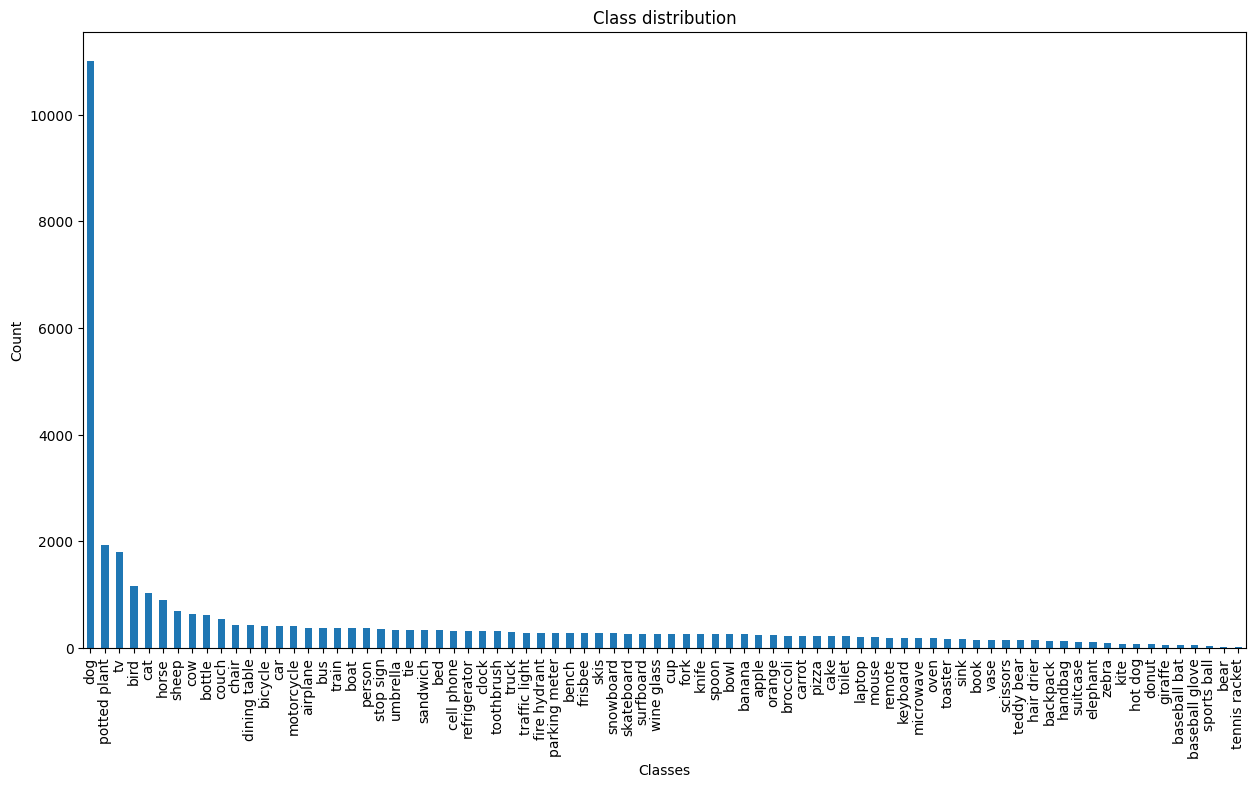

In [ ]:
# Get the number of samples for each object class
class_counts = shapes_df.value_counts()

# Lọc class_names để chỉ chứa các lớp có trong class_counts
filtered_class_names = [class_name for class_name in class_names if class_name in class_counts.index]

# Tạo một biểu đồ với kích thước lớn hơn
plt.figure(figsize=(15, 8))

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')

# Xoay các nhãn trên trục x để dễ đọc hơn
plt.xticks(range(len(filtered_class_names)), filtered_class_names, rotation=90)  # Set the x-axis tick labels

# Hiển thị biểu đồ
plt.show()

#### Add background class

In [ ]:
# Prepend a `background` class to the list of class names
class_names = ['background']+class_names

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names, columns=["Class Names"])

,Class Names
0,background
1,dog
2,potted plant
3,tv
4,bird
5,cat
6,horse
7,sheep
8,cow
9,bottle


#### Generate a color map

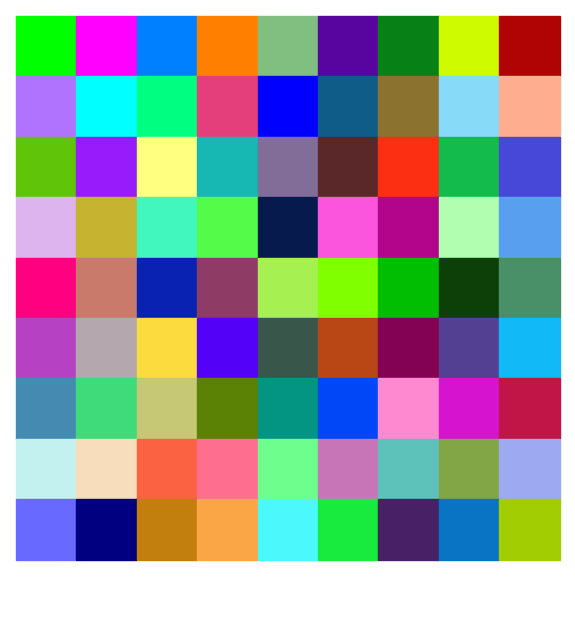

In [ ]:
# 80 class
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [ ]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [ ]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

In [ ]:
# convert_coco_poly_to_mask?
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)

    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

## Loading the img key

In [ ]:
# Get the list of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

# Define the percentage of the images that should be used for training
train_pct = 0.8
val_pct = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))
# val_split = int(len(img_keys)*(val_pct))

# Split the subset of image paths into training and validation sets
train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')

Training Samples:,4000
Validation Samples:,1000


In [ ]:
error_files =['000000320706', '000000330554', '000000064574', '000000370999', '000000041488',
              '000000514540', '000000101022', '000000226111', '000000098497', '000000310622',
              '000000374727', '000000404601', '000000402096', '000000461275', '000000476491',
              '000000049091', '000000173183', '000000228771', '000000268996', '000000278006',
              '000000042888', '000000344611', '000000121153', '000000447789', '000000458790',
              '000000025593', '000000176701', '000000058636', '000000556498', '000000528977',
              '000000198915', '000000261796', '000000267946', '000000477118', '000000560371',
              '000000308391', '000000312549', '000000542073', '000000200152', '000000550939',
              '000000270386', '000000502910', '000000240767', '000000127135', '000000536343',
              '000000382734', '000000481404', '000000260657', '000000171050']





# IOU

```
# This is formatted as code
```



In [ ]:
# The name for the project
project_name = f"pytorch-mask-r-cnn-instance-segmentation-custom-data"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
dataset_dir = Path("./coco/dataset/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

pd.Series({
    "Project Directory:": project_dir,
    "Dataset Directory:": dataset_dir
}).to_frame().style.hide(axis='columns')
# Set the name of the dataset
dataset_name = 'val2017'
# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# /content/gdrive/MyDrive/TrainPBL-customData/pytorch-mask-r-cnn-instance-segmentation-custom-data/2024-06-09_05-23-18/maskrcnn_resnet50_fpn_v2.pth
model_path = './pytorch-mask-r-cnn-instance-segmentation-custom-data/2024-06-09_05-23-18/maskrcnn_resnet50_fpn_v2.pth'
# Initialize the Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier and mask predictor
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the number of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype)

# Load the model state from the file
model.load_state_dict(torch.load(model_path, map_location=device))

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 138MB/s]


In [ ]:
import torch
import numpy as np
import numpy as np


def compute_mask_ious(target,pred_masks ):
    intersection = np.logical_and(target, pred_masks)
    union = np.logical_or(target, pred_masks)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [ ]:
def get_predic(sample_img):
  model.eval();

  # Ensure the model and input data are on the same device
  model.to(device)
  input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(sample_img)[None].to(device)

  # Make a prediction with the model
  with torch.no_grad():
      model_output = model(input_tensor)
  # Set the confidence threshold
  threshold = 0.5

  # Move model output to the CPU
  model_output = move_data_to_device(model_output, 'cpu')

  # Filter the output based on the confidence threshold
  scores_mask = model_output[0]['scores'] > threshold
  # Scale the predicted bounding boxes
  pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask], format='xyxy', canvas_size=sample_img.size[::-1])
  # Get the class names for the predicted label indices
  pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

  # Extract the confidence scores
  pred_scores = model_output[0]['scores']


  # Convert masks to boolean after resizing
  # Scale and stack the predicted segmentation masks
  pred_masks = transforms.functional.resize(model_output[0]['masks'][scores_mask].unsqueeze(0), size=sample_img.size[::-1]).squeeze(0) # Resize masks
  #pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])
  pred = {
      'masks': pred_masks,
      'boxes': pred_bboxes,
      'labels': pred_labels
  }
  return pred

In [ ]:
def get_target(file_id, sample_img):
  if not isinstance(annotation_df.loc[file_id]['Annotation'], pd.Series):
      shape_points = annotation_df.loc[file_id]['Annotation']['segmentation']
      xy_coords = []

      for points in shape_points:
          xy_pair = []
          for i in range(0, len(points), 2):
            # Check if both x and y can be converted to floats
            if isinstance(points[i], (int, float)) and isinstance(points[i+1], (int, float)):
              xy_pair.append((float(points[i]), float(points[i+1])))
          if xy_pair:
                  # print(xy_pair)
                  xy_coords.append(xy_pair)
      bboxes = annotation_df.loc[file_id]['Annotation']['bbox']

  else:
      shape_points = [shape['segmentation'] for shape in annotation_df.loc[file_id]['Annotation']]
      xy_coords = []
      for points_list in shape_points:
        for points in points_list:
          xy_pair = []
          for i in range(0, len(points), 2):
            # Check if both x and y can be converted to floats
            if isinstance(points[i], (int, float)) and isinstance(points[i+1], (int, float)):
              xy_pair.append((float(points[i]), float(points[i+1])))
          if xy_pair:
                  # print(xy_pair)
                  xy_coords.append(xy_pair)
      bboxes = [shape['bbox'] for shape in annotation_df.loc[file_id]['Annotation']]

  labels = [shape for shape in annotation_df.loc[file_id]['Category Name']]

  # Generate mask images from polygons
  mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]

  # Convert mask images to tensors and stack them correctly
  masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
  # Generate bounding box annotations from segmentation masks

  # Convert bboxes to a PyTorch tensor
  bboxes = torchvision.ops.box_convert(torch.tensor(bboxes), in_fmt='xywh', out_fmt='xyxy')

  # Get colors for dataset sample
  sample_colors = [int_colors[i % len(int_colors)] for i in range(masks.shape[0])]
  if not isinstance(annotation_df.loc[file_id]['Annotation'], pd.Series):
    targets = {
        'masks': Mask(masks),
        'boxes': bboxes,
        'labels': labels
    }
  else:
    targets = {
        'masks': Mask(masks),
        'boxes': bboxes,
        'labels': torch.Tensor([class_names.index(label) for label in labels])
    }
  # Convert bounding boxes to BoundingBoxes object
  targets['boxes'] = BoundingBoxes(data=targets['boxes'], format='xyxy', canvas_size=sample_img.size[::-1])

  # Resize the masks to match the sanitized image
  targets['masks'] = transforms.functional.resize(targets['masks'].unsqueeze(0), size=sample_img.size[::-1]).squeeze(0)

  return targets


In [ ]:
file_id = '000000523811'
sample_img = Image.open(img_dict[file_id]).convert('RGB')

get_target(file_id, sample_img)['masks']

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [ ]:
val_keys = [key for key in val_keys if key not in error_files]
n_values =0
avg_precisions = []
avg_recalls = []
avg_f1_scores = []
avg_ious = []
sum_precision = 0
sum_recall = 0
sum_f1_score = 0
sum_iou = 0

for file_id in val_keys:
  sample_img = Image.open(img_dict[file_id]).convert('RGB')
  target_masks =get_target(file_id, sample_img)['masks']
  pred_masks = get_predic(sample_img)['masks']

  pred_masks = torch.sum(pred_masks, dim=0)
  pred_masks = pred_masks > 0
  pred_masks = pred_masks.squeeze(0).cpu().numpy()

  target_masks = torch.sum(target_masks, dim=0)
  target_masks = target_masks > 0
  target_masks = target_masks.squeeze(0).cpu().numpy()

  ious = compute_mask_ious(pred_masks, target_masks)

  # Define IoU threshold
  iou_threshold = 0.5

  # Compute TP, FP and FN
  tp = np.sum(ious > iou_threshold)
  fp = np.sum(ious <= iou_threshold)
  fn = len(target_masks) - tp

  # Compute Precision, Recall and F1 score
  precision = tp / (tp + fp) if tp + fp > 0 else 0
  recall = tp / (tp + fn) if tp + fn > 0 else 0
  f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
  sum_precision += precision
  sum_recall += recall
  sum_f1_score += f1_score
  sum_iou += ious
  # Compute the average values
  n_values += 1
  print(ious)
  print(n_values)
  avg_precision = sum_precision / n_values
  avg_recall = sum_recall / n_values
  avg_f1_score = sum_f1_score / n_values
  avg_iou = sum_iou / n_values

  # Add the average values to the lists
  avg_precisions.append(avg_precision)
  avg_recalls.append(avg_recall)
  avg_f1_scores.append(avg_f1_score)
  avg_ious.append(avg_iou)

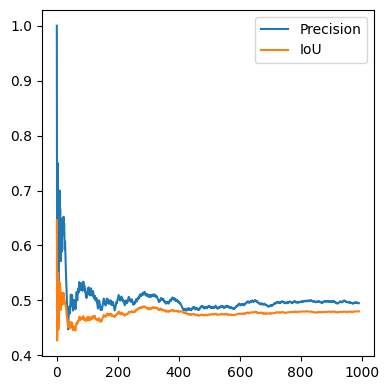

Precision: 0.4949596774193548,IoU: 0.48000822200236076


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

# Plot all the lines on the same graph
plt.plot(avg_precisions, label='Precision')
# plt.plot(avg_recalls, label='Recall')
# plt.plot(avg_f1_scores, label='F1 Score')
plt.plot(avg_ious, label='IoU')

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()
print(f'Precision: {avg_precisions[-1]},IoU: {avg_ious[-1]}')

In [ ]:
np.save('/content/drive/MyDrive/avg_precisions.npy', avg_precisions)
np.save('/content/drive/MyDrive/avg_recalls.npy', avg_recalls)
np.save('/content/drive/MyDrive/avg_f1_scores.npy', avg_f1_scores)
np.save('/content/drive/MyDrive/avg_ious.npy', avg_ious)

In [ ]:
avg_precisions = np.load('/content/drive/MyDrive/avg_precisions.npy')
avg_ious = np.load('/content/drive/MyDrive/avg_ious.npy')